# Descripción del proyecto
Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B. (Sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios y las usuarias participan en experimentos.

# Descripción de los datos
Cada entrada de registro es una acción de usuario o un evento.

EventName: nombre del evento.

DeviceIDHash: identificador de usuario unívoco.

EventTimestamp: hora del evento.

ExpId: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.


## Paso 1. Abrir el archivo de datos y leer la información general

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

In [2]:
df = pd.read_csv("/datasets/logs_exp_us.csv", delimiter='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Paso 2. Preparar los datos para el análisis

In [4]:
# Cambiar nombres de las columnas
df.columns = ['event_name', 'device_id', 'event_timestamp', 'exp_id']

In [5]:
# Comprobar valores ausentes
print(df.isnull().sum())

event_name         0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64


In [6]:
df.head()

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [7]:
# Convertir 'event_timestamp' a datetime
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')
df.head()

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [8]:
# Crear columnas separadas para fecha y hora
df['date'] = df['event_timestamp'].dt.date
df['time'] = df['event_timestamp'].dt.time
df.head()

,event_name,device_id,event_timestamp,exp_id,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


## Paso 3. Estudiar y comprobar los datos

### ¿Cuántos eventos hay en los registros?

In [9]:
# Contar el número total de eventos
total_events = len(df)

# Contar el número de eventos únicos
unique_events = df['event_name'].nunique()

# Mostrar los resultados
print(f"Número total de eventos: {total_events}")
print(f"Número de eventos únicos: {unique_events}")


Número total de eventos: 244126
Número de eventos únicos: 5


### ¿Cuántos usuarios y usuarias hay en los registros?

In [10]:
# Contar el número de usuarios únicos
unique_users = df['device_id'].nunique()

# Mostrar el resultado
print(f"Número de usuarios únicos: {unique_users}")


Número de usuarios únicos: 7551


### ¿Cuál es el promedio de eventos por usuario?

In [11]:
# Calcular el promedio de eventos por usuario
average_events_per_user = total_events / unique_users

# Mostrar el resultado
print(f"Promedio de eventos por usuario: {average_events_per_user:.2f}")

Promedio de eventos por usuario: 32.33


### ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima.

In [12]:
# Encontrar la fecha mínima y máxima
min_date = df['event_timestamp'].min()
max_date = df['event_timestamp'].max()

# Mostrar las fechas
print(f"Fecha mínima: {min_date}")
print(f"Fecha máxima: {max_date}")


Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17


### histograma por fecha y hora

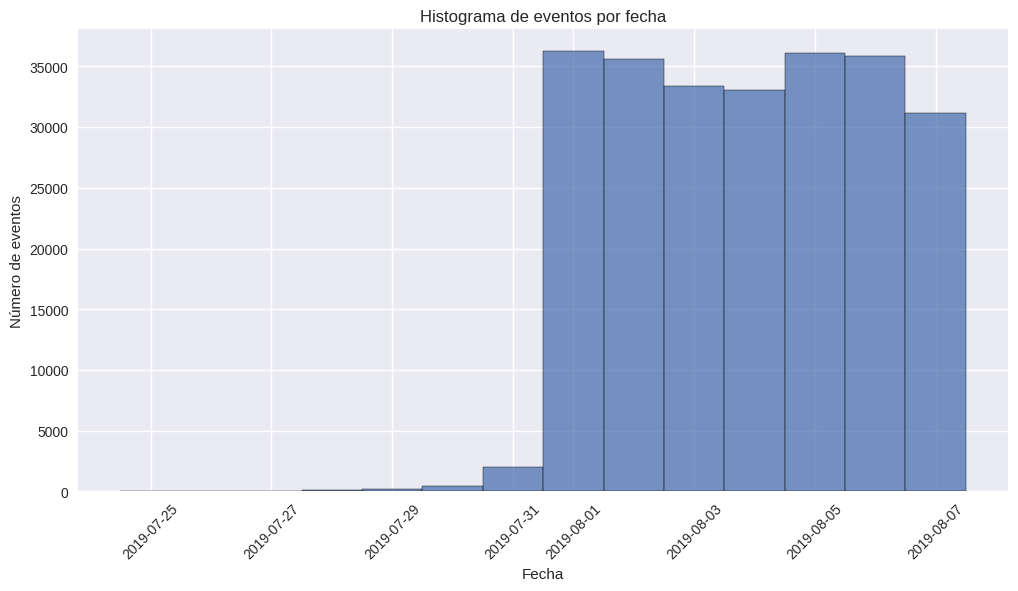

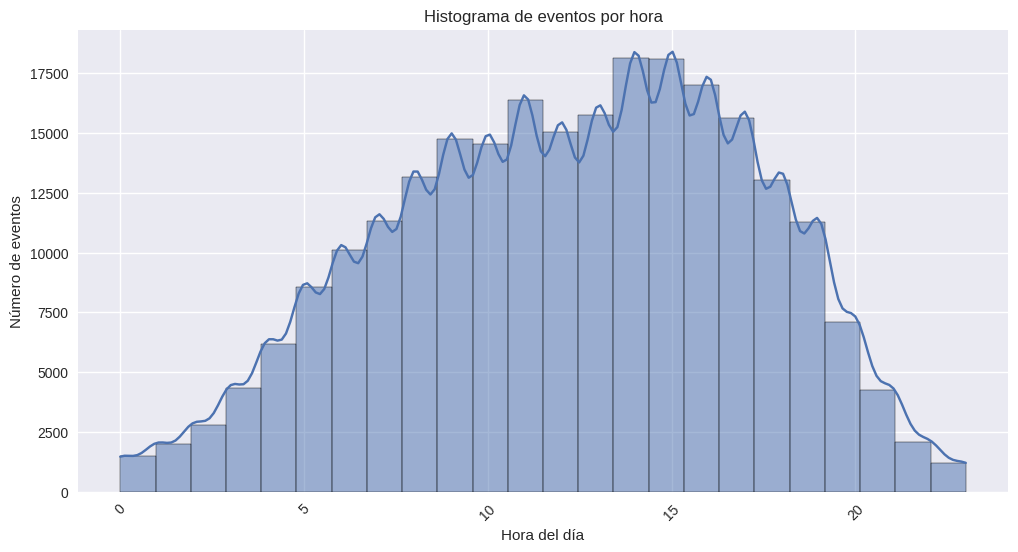

In [13]:
# Crear una columna de solo fechas para el histograma
df['date'] = df['event_timestamp'].dt.date

# Trazar un histograma de eventos por fecha
plt.style.use('seaborn')
plt.figure(figsize=(12, 6))
sns.histplot(df['date'], bins=30)
plt.title('Histograma de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.show()

# Crear una columna de solo horas para el histograma
df['hour'] = df['event_timestamp'].dt.hour

# Trazar un histograma de eventos por hora
plt.figure(figsize=(12, 6))
sns.histplot(df['hour'], bins=24, kde=True)
plt.title('Histograma de eventos por hora')
plt.xlabel('Hora del día')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.show()


### ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?

#### Periodo de tiempo cubierto por los datos:

Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17

#### Evaluación de la completitud de los datos:

Los histogramas muestran que los datos no están igualmente completos para todo el periodo. Los datos empiezan a ser consistentes a partir del 2019-08-01.

### Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

In [14]:
# Filtrar los datos para obtener solo los datos completos a partir del 2019-08-01
complete_data_start_date = pd.Timestamp('2019-08-01')
df_complete = df[df['event_timestamp'] >= complete_data_start_date]

# Encontrar la nueva fecha mínima y máxima para los datos completos
min_date_complete = df_complete['event_timestamp'].min()
max_date_complete = df_complete['event_timestamp'].max()

# Mostrar las nuevas fechas
print(f"Fecha mínima de datos completos: {min_date_complete}")
print(f"Fecha máxima de datos completos: {max_date_complete}")

# Contar el número total de eventos en los datos completos
total_events_complete = len(df_complete)

# Contar el número de usuarios únicos en los datos completos
unique_users_complete = df_complete['device_id'].nunique()

# Calcular el promedio de eventos por usuario en los datos completos
average_events_per_user_complete = total_events_complete / unique_users_complete

# Mostrar los resultados
print(f"Número total de eventos (datos completos): {total_events_complete}")
print(f"Número de usuarios únicos (datos completos): {unique_users_complete}")
print(f"Promedio de eventos por usuario (datos completos): {average_events_per_user_complete:.2f}")

Fecha mínima de datos completos: 2019-08-01 00:07:28
Fecha máxima de datos completos: 2019-08-07 21:15:17
Número total de eventos (datos completos): 241298
Número de usuarios únicos (datos completos): 7534
Promedio de eventos por usuario (datos completos): 32.03


### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [15]:
# Resultados antes de filtrar
total_events_before = 244126
unique_users_before = 7551
average_events_per_user_before = 32.33

# Resultados después de filtrar
total_events_after = 241298
unique_users_after = 7534
average_events_per_user_after = 32.03

# Calcular la diferencia en número de eventos y usuarios
events_lost = total_events_before - total_events_after
users_lost = unique_users_before - unique_users_after

# Mostrar la comparación
print(f"Eventos perdidos: {events_lost}")
print(f"Usuarios perdidos: {users_lost}")
print(f"Porcentaje de eventos perdidos: {events_lost / total_events_before * 100:.2f}%")
print(f"Porcentaje de usuarios perdidos: {users_lost / unique_users_before * 100:.2f}%")


Eventos perdidos: 2828
Usuarios perdidos: 17
Porcentaje de eventos perdidos: 1.16%
Porcentaje de usuarios perdidos: 0.23%


### Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [16]:
# Verificar la presencia de los tres grupos experimentales en los datos completos
experimental_groups = df_complete['exp_id'].unique()

# Mostrar los grupos experimentales presentes
print(f"Grupos experimentales presentes: {experimental_groups}")

# Verificar el conteo de usuarios en cada grupo experimental
group_counts = df_complete['exp_id'].value_counts()

# Mostrar el conteo de usuarios en cada grupo experimental
print("Conteo de usuarios en cada grupo experimental:")
print(group_counts)


Grupos experimentales presentes: [246 247 248]
Conteo de usuarios en cada grupo experimental:
248    84726
246    79425
247    77147
Name: exp_id, dtype: int64


## Paso 4. Estudiar el embudo de eventos

### Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [17]:
# Contar la frecuencia de cada evento en los datos completos
event_frequencies = df_complete['event_name'].value_counts()

# Ordenar los eventos por frecuencia
event_frequencies_sorted = event_frequencies.sort_values(ascending=False)

# Mostrar los eventos y su frecuencia
print("Eventos ordenados por frecuencia:")
print(event_frequencies_sorted)


Eventos ordenados por frecuencia:
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event_name, dtype: int64


### Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [18]:
# Contar el número de usuarios únicos que realizaron cada evento
users_per_event = df_complete.groupby('event_name')['device_id'].nunique()

# Ordenar los eventos por el número de usuarios únicos
users_per_event_sorted = users_per_event.sort_values(ascending=False)

# Calcular la proporción de usuarios que realizaron la acción al menos una vez
total_unique_users = df_complete['device_id'].nunique()
proportion_per_event = users_per_event_sorted / total_unique_users

# Crear un DataFrame para mostrar los resultados
event_analysis = pd.DataFrame({
    'event_name': users_per_event_sorted.index,
    'unique_users': users_per_event_sorted.values,
    'proportion_of_users': proportion_per_event.values
})

# Mostrar los resultados
print(event_analysis)


                event_name  unique_users  proportion_of_users
0         MainScreenAppear          7419             0.984736
1       OffersScreenAppear          4593             0.609636
2         CartScreenAppear          3734             0.495620
3  PaymentScreenSuccessful          3539             0.469737
4                 Tutorial           840             0.111495


### ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

MainScreenAppear: Este evento probablemente ocurre cuando un usuario abre la aplicación y llega a la pantalla principal.

OffersScreenAppear: Este evento podría ocurrir cuando un usuario navega a una sección de ofertas.

CartScreenAppear: Este evento sucede cuando un usuario añade productos al carrito y luego va a la pantalla del carrito.

PaymentScreenSuccessful: Este evento indica que un usuario ha completado con éxito una transacción.

Tutorial: Este evento podría ocurrir en cualquier momento, especialmente para nuevos usuarios que interactúan con la aplicación por primera vez.



#### Posible secuencia de eventos

1- MainScreenAppear

2- CartScreenAppear

3- PaymentScreenSuccessful

4- Tutorial (puede ocurrir en cualquier momento y no necesariamente forma parte de la secuencia principal de compra)

#### Embudo de conversión
Para calcular el embudo de conversión, vamos a considerar los eventos que son parte del proceso de compra:

1- MainScreenAppear

2- OffersScreenAppear

3- CartScreenAppear

4- PaymentScreenSuccessful

In [19]:
# Ordenar los eventos según la probable secuencia
event_sequence = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Filtrar los eventos que están en la secuencia
funnel_data = event_analysis[event_analysis['event_name'].isin(event_sequence)].copy()

# Reordenar el DataFrame según la secuencia de eventos
funnel_data['event_order'] = funnel_data['event_name'].apply(lambda x: event_sequence.index(x))
funnel_data = funnel_data.sort_values('event_order').reset_index(drop=True)

# Eliminar la columna 'event_order' ya que no es necesaria para mostrar los resultados
funnel_data = funnel_data.drop(columns=['event_order'])

# Mostrar el embudo de conversión
print(funnel_data)


                event_name  unique_users  proportion_of_users
0         MainScreenAppear          7419             0.984736
1       OffersScreenAppear          4593             0.609636
2         CartScreenAppear          3734             0.495620
3  PaymentScreenSuccessful          3539             0.469737


### Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [20]:
# Crear una lista para almacenar las proporciones de conversión
conversion_rates = []

# Iterar sobre el embudo de conversión para calcular las proporciones
for i in range(len(funnel_data) - 1):
    current_stage_users = funnel_data.loc[i, 'unique_users']
    next_stage_users = funnel_data.loc[i + 1, 'unique_users']
    conversion_rate = next_stage_users / current_stage_users
    conversion_rates.append(conversion_rate)

# Crear un DataFrame para mostrar las proporciones de conversión
stages = funnel_data['event_name'].tolist()
conversion_data = {
    'from_stage': stages[:-1],
    'to_stage': stages[1:],
    'conversion_rate': conversion_rates
}
conversion_df = pd.DataFrame(conversion_data)

# Mostrar las proporciones de conversión
print(conversion_df)


           from_stage                 to_stage  conversion_rate
0    MainScreenAppear       OffersScreenAppear         0.619086
1  OffersScreenAppear         CartScreenAppear         0.812976
2    CartScreenAppear  PaymentScreenSuccessful         0.947777


### ¿En qué etapa pierdes más usuarios y usuarias?

In [21]:
# Encontrar la etapa con la tasa de conversión más baja
lowest_conversion_stage = conversion_df.loc[conversion_df['conversion_rate'].idxmin()]

# Mostrar la etapa con mayor pérdida de usuarios
print("Etapa con mayor pérdida de usuarios:")
print(lowest_conversion_stage)


Etapa con mayor pérdida de usuarios:
from_stage           MainScreenAppear
to_stage           OffersScreenAppear
conversion_rate              0.619086
Name: 0, dtype: object


### ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [22]:
# Obtener el número de usuarios que realizaron el primer evento y el evento final
total_users_first_event = funnel_data.loc[funnel_data['event_name'] == 'MainScreenAppear', 'unique_users'].values[0]
total_users_final_event = funnel_data.loc[funnel_data['event_name'] == 'PaymentScreenSuccessful', 'unique_users'].values[0]

# Calcular la proporción de usuarios que completan todo el viaje
completion_rate = total_users_final_event / total_users_first_event

# Calcular el porcentaje
completion_percentage = completion_rate * 100

# Mostrar el porcentaje
print(f"Porcentaje de usuarios que hacen todo el viaje desde el primer evento hasta el pago: {completion_percentage:.2f}%")


Porcentaje de usuarios que hacen todo el viaje desde el primer evento hasta el pago: 47.70%


## Paso 5. Estudiar los resultados del experimento

### ¿Cuántos usuarios y usuarias hay en cada grupo?

In [23]:
# Contar el número de usuarios únicos en cada grupo experimental
users_per_group = df_complete.groupby('exp_id')['device_id'].nunique()

# Mostrar el conteo de usuarios en cada grupo experimental
print("Número de usuarios en cada grupo experimental:")
print(users_per_group)


Número de usuarios en cada grupo experimental:
exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


### Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [24]:
# Filtrar los datos para los eventos relevantes
df_246 = df_complete[df_complete['exp_id'] == 246]
df_247 = df_complete[df_complete['exp_id'] == 247]

# Calcular el número de usuarios que realizaron "PaymentScreenSuccessful" en cada grupo
success_246 = df_246[df_246['event_name'] == 'PaymentScreenSuccessful']['device_id'].nunique()
success_247 = df_247[df_247['event_name'] == 'PaymentScreenSuccessful']['device_id'].nunique()

# Calcular el número total de usuarios en cada grupo
total_246 = df_246['device_id'].nunique()
total_247 = df_247['device_id'].nunique()

# Realizar el z-test de proporciones
count = np.array([success_246, success_247])
nobs = np.array([total_246, total_247])
z_stat, p_value = proportions_ztest(count, nobs)

# Mostrar los resultados
conversion_246 = success_246 / total_246
conversion_247 = success_247 / total_247

print(f"Grupo 246: {conversion_246 * 100:.2f}%")
print(f"Grupo 247: {conversion_247 * 100:.2f}%")
print(f"z-statistic: {z_stat}")
print(f"p-value: {p_value}")

Grupo 246: 48.31%
Grupo 247: 46.08%
z-statistic: 1.5779948491596598
p-value: 0.11456679313141847


#### Evaluación de la Significancia Estadística
El nivel de significancia comúnmente utilizado es α=0.05. Si el valor p es menor que α, rechazamos la hipótesis nula y concluimos que hay una diferencia estadísticamente significativa entre los grupos. Si el valor p es mayor que α, no rechazamos la hipótesis nula.

#### Comparación con el Nivel de Significancia
p-value: 0.11456679313141847
Este valor p es mayor que α=0.05, lo que indica que:

No hay evidencia suficiente para rechazar la hipótesis nula. 

La diferencia en las tasas de conversión entre los grupos 246 y 247 no es estadísticamente significativa.

### Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. 

In [25]:

def test_event_proportion(event_name, df, group1, group2):
    """
    Compara la proporción de usuarios que realizaron un evento específico entre dos grupos de control usando z-test de proporciones.
    
    Args:
    event_name (str): El nombre del evento a analizar.
    df (pd.DataFrame): El dataframe que contiene los datos.
    group1 (int): El ID del primer grupo de control.
    group2 (int): El ID del segundo grupo de control.
    
    Returns:
    dict: Resultados de la prueba incluyendo las proporciones y valores p.
    """
    # Filtrar los datos para cada grupo
    df_group1 = df[df['exp_id'] == group1]
    df_group2 = df[df['exp_id'] == group2]
    
    # Calcular la proporción de usuarios que realizaron el evento en cada grupo
    users_group1 = df_group1['device_id'].nunique()
    users_group2 = df_group2['device_id'].nunique()
    event_users_group1 = df_group1[df_group1['event_name'] == event_name]['device_id'].nunique()
    event_users_group2 = df_group2[df_group2['event_name'] == event_name]['device_id'].nunique()
    proportion_group1 = event_users_group1 / users_group1
    proportion_group2 = event_users_group2 / users_group2
    
    # Realizar el z-test de proporciones
    count = np.array([event_users_group1, event_users_group2])
    nobs = np.array([users_group1, users_group2])
    z_stat, p_value = proportions_ztest(count, nobs)
    
    # Devolver los resultados
    return {
        'event_name': event_name,
        'proportion_group1': proportion_group1,
        'proportion_group2': proportion_group2,
        'z_stat': z_stat,
        'p_value': p_value
    }

# Obtener el evento más popular
most_popular_event = df_complete['event_name'].value_counts().idxmax()

# Calcular y mostrar los resultados para el evento más popular
result = test_event_proportion(most_popular_event, df_complete, 246, 247)

# Formatear e imprimir los resultados en orden
print(f"Resultados para el evento más popular ({most_popular_event}):")
for key, value in result.items():
    print(f"{key}: {value}")


Resultados para el evento más popular (MainScreenAppear):
event_name: MainScreenAppear
proportion_group1: 0.9863123993558777
proportion_group2: 0.9852765618782332
z_stat: 0.3093441851418436
p_value: 0.7570597232046099


### Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [26]:
# Definir una lista para almacenar los resultados de todos los eventos
all_event_results = []

# Obtener la lista de eventos únicos
unique_events = df_complete['event_name'].unique()

# Iterar sobre todos los eventos y calcular los resultados
for event in unique_events:
    result = test_event_proportion(event, df_complete, 246, 247)
    all_event_results.append(result)

# Convertir los resultados a un DataFrame para una mejor visualización
all_event_results_df = pd.DataFrame(all_event_results)

# Mostrar los resultados
print("Resultados de todos los eventos:")
print(all_event_results_df)


Resultados de todos los eventos:
                event_name  proportion_group1  proportion_group2    z_stat  \
0                 Tutorial           0.111916           0.112614 -0.078161   
1         MainScreenAppear           0.986312           0.985277  0.309344   
2       OffersScreenAppear           0.620773           0.604855  1.154988   
3         CartScreenAppear           0.509662           0.492638  1.203369   
4  PaymentScreenSuccessful           0.483092           0.460804  1.577995   

    p_value  
0  0.937700  
1  0.757060  
2  0.248095  
3  0.228834  
4  0.114567  


#### Conclusión
p-value: Para cada evento, el valor p es mayor que el nivel de significancia comúnmente utilizado (α=0.05). Esto significa que no hay evidencia suficiente para rechazar la hipótesis nula de que no hay diferencia significativa entre las proporciones de los grupos 246 y 247 para cada evento.

### Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [27]:
def test_event_proportion_multiple(event_name, df, group1, group2, group_experimental):
    """
    Compara la proporción de usuarios que realizaron un evento específico entre dos grupos de control y un grupo experimental usando z-test de proporciones.
    
    Args:
    event_name (str): El nombre del evento a analizar.
    df (pd.DataFrame): El dataframe que contiene los datos.
    group1 (int): El ID del primer grupo de control.
    group2 (int): El ID del segundo grupo de control.
    group_experimental (int): El ID del grupo experimental.
    
    Returns:
    dict: Resultados de la prueba incluyendo las proporciones y valores p.
    """
    # Filtrar los datos para cada grupo
    df_group1 = df[df['exp_id'] == group1]
    df_group2 = df[df['exp_id'] == group2]
    df_experimental = df[df['exp_id'] == group_experimental]
    
    # Calcular la proporción de usuarios que realizaron el evento en cada grupo
    users_group1 = df_group1['device_id'].nunique()
    users_group2 = df_group2['device_id'].nunique()
    users_experimental = df_experimental['device_id'].nunique()
    event_users_group1 = df_group1[df_group1['event_name'] == event_name]['device_id'].nunique()
    event_users_group2 = df_group2[df_group2['event_name'] == event_name]['device_id'].nunique()
    event_users_experimental = df_experimental[df_experimental['event_name'] == event_name]['device_id'].nunique()
    proportion_group1 = event_users_group1 / users_group1
    proportion_group2 = event_users_group2 / users_group2
    proportion_experimental = event_users_experimental / users_experimental
    
    # Combinar los grupos de control
    df_control_combined = df[df['exp_id'].isin([group1, group2])]
    users_control_combined = df_control_combined['device_id'].nunique()
    event_users_control_combined = df_control_combined[df_control_combined['event_name'] == event_name]['device_id'].nunique()
    proportion_control_combined = event_users_control_combined / users_control_combined
    
    # Realizar las pruebas z de proporciones
    count_group1_exp = np.array([event_users_group1, event_users_experimental])
    count_group2_exp = np.array([event_users_group2, event_users_experimental])
    count_combined_exp = np.array([event_users_control_combined, event_users_experimental])
    nobs_group1_exp = np.array([users_group1, users_experimental])
    nobs_group2_exp = np.array([users_group2, users_experimental])
    nobs_combined_exp = np.array([users_control_combined, users_experimental])

    z_stat_group1, p_value_group1 = proportions_ztest(count_group1_exp, nobs_group1_exp)
    z_stat_group2, p_value_group2 = proportions_ztest(count_group2_exp, nobs_group2_exp)
    z_stat_combined, p_value_combined = proportions_ztest(count_combined_exp, nobs_combined_exp)
    
    # Devolver los resultados
    return {
        'event_name': event_name,
        'proportion_group1': proportion_group1,
        'proportion_group2': proportion_group2,
        'proportion_experimental': proportion_experimental,
        'proportion_control_combined': proportion_control_combined,
        'z_stat_group1': z_stat_group1,
        'p_value_group1': p_value_group1,
        'z_stat_group2': z_stat_group2,
        'p_value_group2': p_value_group2,
        'z_stat_combined': z_stat_combined,
        'p_value_combined': p_value_combined
    }

# Obtener la lista de eventos únicos
unique_events = df_complete['event_name'].unique()

# Definir una lista para almacenar los resultados de todos los eventos
all_event_results = []

# Iterar sobre todos los eventos y calcular los resultados
for event in unique_events:
    result = test_event_proportion_multiple(event, df_complete, 246, 247, 248)
    all_event_results.append(result)

# Convertir los resultados a un DataFrame para una mejor visualización
all_event_results_df = pd.DataFrame(all_event_results)

# Mostrar los resultados
print("Resultados de todos los eventos comparados con el grupo experimental:")
print(all_event_results_df)


Resultados de todos los eventos comparados con el grupo experimental:
                event_name  proportion_group1  proportion_group2  \
0                 Tutorial           0.111916           0.112614   
1         MainScreenAppear           0.986312           0.985277   
2       OffersScreenAppear           0.620773           0.604855   
3         CartScreenAppear           0.509662           0.492638   
4  PaymentScreenSuccessful           0.483092           0.460804   

   proportion_experimental  proportion_control_combined  z_stat_group1  \
0                 0.109972                     0.112267       0.219283   
1                 0.982657                     0.985791       1.047276   
2                 0.603469                     0.612768       1.258082   
3                 0.484825                     0.501101       1.759874   
4                 0.465510                     0.471883       1.247388   

   p_value_group1  z_stat_group2  p_value_group2  z_stat_combined  \
0      

### Conclusiones
##### No hay diferencias significativas:

En ninguno de los eventos analizados se encontraron diferencias estadísticamente significativas entre los grupos de control (246 y 247) y el grupo experimental (248). Los valores p son mayores que el nivel de significancia comúnmente utilizado (α=0.05), lo que indica que no podemos rechazar la hipótesis nula de que no hay diferencias entre las proporciones de usuarios que realizaron los eventos en los diferentes grupos.

### ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

In [28]:
# Nivel de significancia original y corregido
alpha = 0.05
number_of_tests = 15
alpha_corr = alpha / number_of_tests

# Definir una lista para almacenar los resultados de todos los eventos con corrección
all_event_results_corrected = []

# Obtener la lista de eventos únicos
unique_events = df_complete['event_name'].unique()

# Iterar sobre todos los eventos y calcular los resultados
for event in unique_events:
    result = test_event_proportion_multiple(event, df_complete, 246, 247, 248)
    result['p_value_group1_corrected'] = result['p_value_group1'] < alpha_corr
    result['p_value_group2_corrected'] = result['p_value_group2'] < alpha_corr
    result['p_value_combined_corrected'] = result['p_value_combined'] < alpha_corr
    all_event_results_corrected.append(result)

# Convertir los resultados a un DataFrame para una mejor visualización
all_event_results_corrected_df = pd.DataFrame(all_event_results_corrected)

# Mostrar los resultados
print("Resultados de todos los eventos comparados con el grupo experimental con corrección de Bonferroni:")
print(all_event_results_corrected_df)

Resultados de todos los eventos comparados con el grupo experimental con corrección de Bonferroni:
                event_name  proportion_group1  proportion_group2  \
0                 Tutorial           0.111916           0.112614   
1         MainScreenAppear           0.986312           0.985277   
2       OffersScreenAppear           0.620773           0.604855   
3         CartScreenAppear           0.509662           0.492638   
4  PaymentScreenSuccessful           0.483092           0.460804   

   proportion_experimental  proportion_control_combined  z_stat_group1  \
0                 0.109972                     0.112267       0.219283   
1                 0.982657                     0.985791       1.047276   
2                 0.603469                     0.612768       1.258082   
3                 0.484825                     0.501101       1.759874   
4                 0.465510                     0.471883       1.247388   

   p_value_group1  z_stat_group2  p_value_group

### Conclusión General
#### Consistencia de Grupos: 

Los grupos de control (246 y 247) y el grupo experimental (248) no muestran diferencias significativas en ninguno de los eventos analizados.

#### Impacto del Cambio de Fuente: 

El cambio de fuente en la aplicación no tuvo un impacto significativo en el comportamiento de los usuarios.

